In [1]:
import os
import sys
import time
from glob import glob
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

import cv2
from PIL import Image
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

# TensorFlow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models

from IPython.display import YouTubeVideo
import albumentations as A
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

print('All modules have been imported')

All modules have been imported


In [2]:
base_skin_dir = "Z:/CV/skin cancer/images/"

#imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
#                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

tile_df = pd.read_csv("Z:/CV/skin cancer/HAM10000_metadata.csv")
tile_df['path'] = tile_df['image_id'].apply(lambda x: os.path.join(base_skin_dir, f"{x}.jpg"))
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
6606,HAM_0005707,ISIC_0029821,nv,follow_up,50.0,male,abdomen,Z:/CV/skin cancer/images/ISIC_0029821.jpg,Melanocytic nevi,4
2607,HAM_0005396,ISIC_0032834,bcc,histo,75.0,male,abdomen,Z:/CV/skin cancer/images/ISIC_0032834.jpg,Basal cell carcinoma,1
6139,HAM_0005367,ISIC_0029743,nv,follow_up,45.0,male,trunk,Z:/CV/skin cancer/images/ISIC_0029743.jpg,Melanocytic nevi,4
8994,HAM_0006458,ISIC_0029221,nv,histo,80.0,male,back,Z:/CV/skin cancer/images/ISIC_0029221.jpg,Melanocytic nevi,4
4404,HAM_0001071,ISIC_0027570,nv,follow_up,50.0,male,trunk,Z:/CV/skin cancer/images/ISIC_0027570.jpg,Melanocytic nevi,4


In [3]:
df = pd.DataFrame() # columns=["filepaths", "labels"]

df['filepaths'] =tile_df['path']
df['labels'] =tile_df['cell_type_idx']
df['labels'] =df['labels'].apply(lambda x: str(x))
df.head()

,filepaths,labels
0,Z:/CV/skin cancer/images/ISIC_0027419.jpg,2
1,Z:/CV/skin cancer/images/ISIC_0025030.jpg,2
2,Z:/CV/skin cancer/images/ISIC_0026769.jpg,2
3,Z:/CV/skin cancer/images/ISIC_0025661.jpg,2
4,Z:/CV/skin cancer/images/ISIC_0031633.jpg,2


In [4]:
df.labels.unique()

array(['2', '4', '3', '5', '6', '1', '0'], dtype=object)

In [5]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=14, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=14, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 
    return train_df, test_df, valid_df    

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  8012   test_df length:  1002   valid_df length:  1001


In [6]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()    
    values=vcounts.tolist() 
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5)) 
        form = {'family': 'serif', 'color': 'blue', 'size': 25} 
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')        
        plt.show()

labels
4    5364
5     890
2     879
1     411
0     262
6     114
3      92
Name: count, dtype: int64


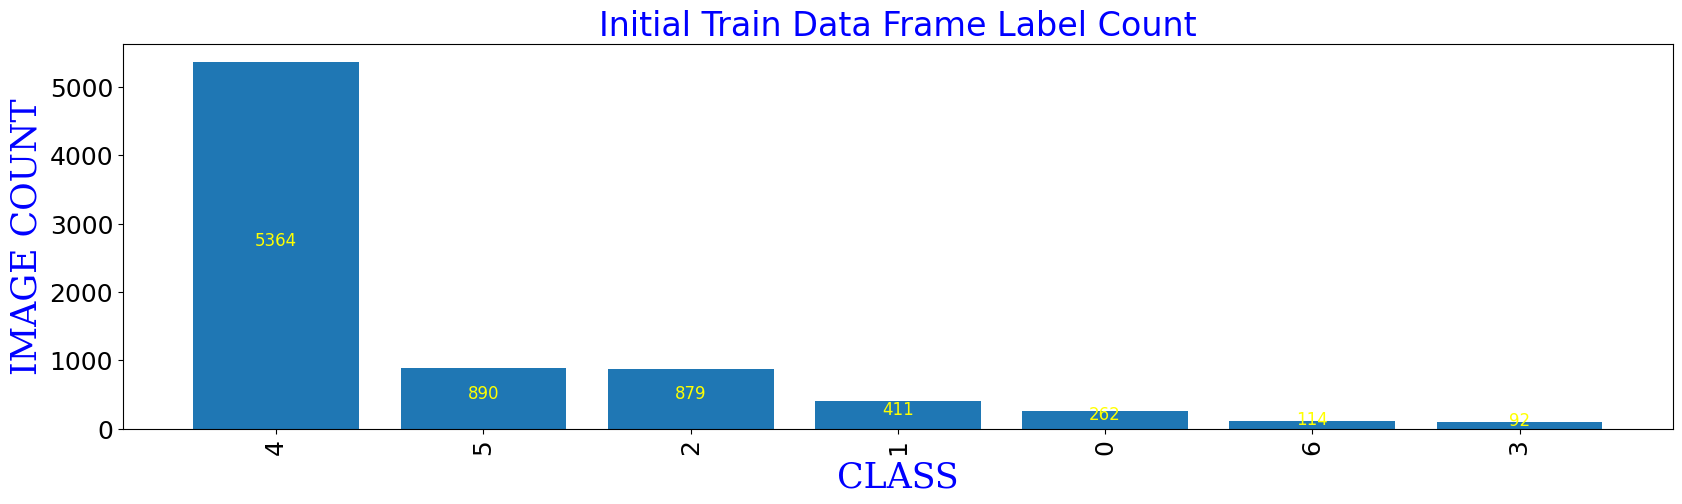

In [7]:
count=train_df['labels'].value_counts()
print (count)
plot_title='Initial Train Data Frame Label Count'
plot_label_count (train_df, plot_title)

In [8]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes= df[column].unique()
    print(classes)
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=500
min_samples= 10
column='labels'
train_df, classes, class_count= trim(train_df, max_samples, min_samples, column)

['4' '5' '0' '1' '2' '6' '3']
dataframe initially is of length  8012  with  7  classes
after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  10
the trimmed dataframe now is of length  2379  with  7  classes


In [9]:
def balance(df, n,column, working_dir, img_size):
    def get_augmented_image(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])    
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0    
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images            
            desc=f'augmenting class {label}'
            for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
                j= i % sample_count
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)                
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=500
working_dir=r'Z:/CV/working'
img_size = (310,640)
column='labels'
train_df=balance(train_df, n,column, working_dir, img_size)

Initial length of dataframe is  2379


augmenting class 0:   0%|                                                                    | 0/238 [00:00<?,…

augmenting class 1:   0%|                                                                     | 0/89 [00:00<?,…

augmenting class 6:   0%|                                                                    | 0/386 [00:00<?,…

augmenting class 3:   0%|                                                                    | 0/408 [00:00<?,…

Total Augmented images created=  1121
Length of augmented dataframe is now  3500


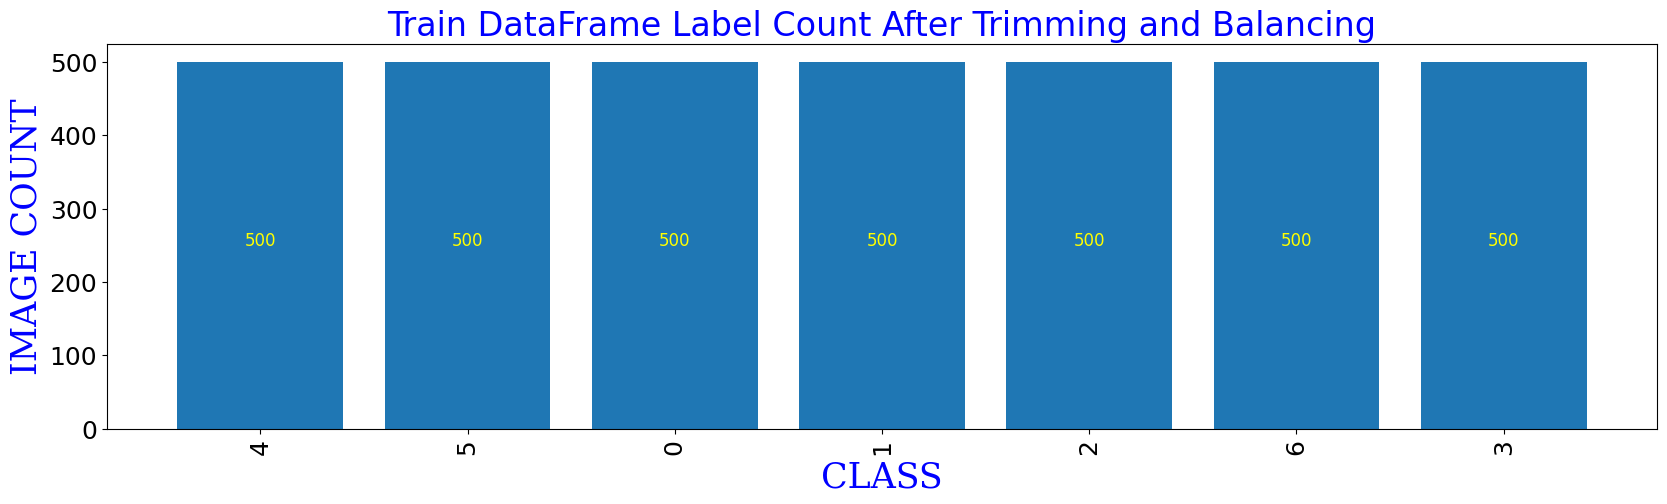

In [10]:
plot_title='Train DataFrame Label Count After Trimming and Balancing'
plot_label_count (train_df, plot_title)

In [11]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

bs=16
ycol='labels'
train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_df, test_df, valid_df, img_size)

Found 3500 validated image filenames belonging to 7 classes.           for train generator 
Found 1001 validated image filenames belonging to 7 classes.           for valid generator 
Found 1002 validated image filenames belonging to 7 classes.           for test generator 
test batch size:  6   test steps:  167  number of classes :  7


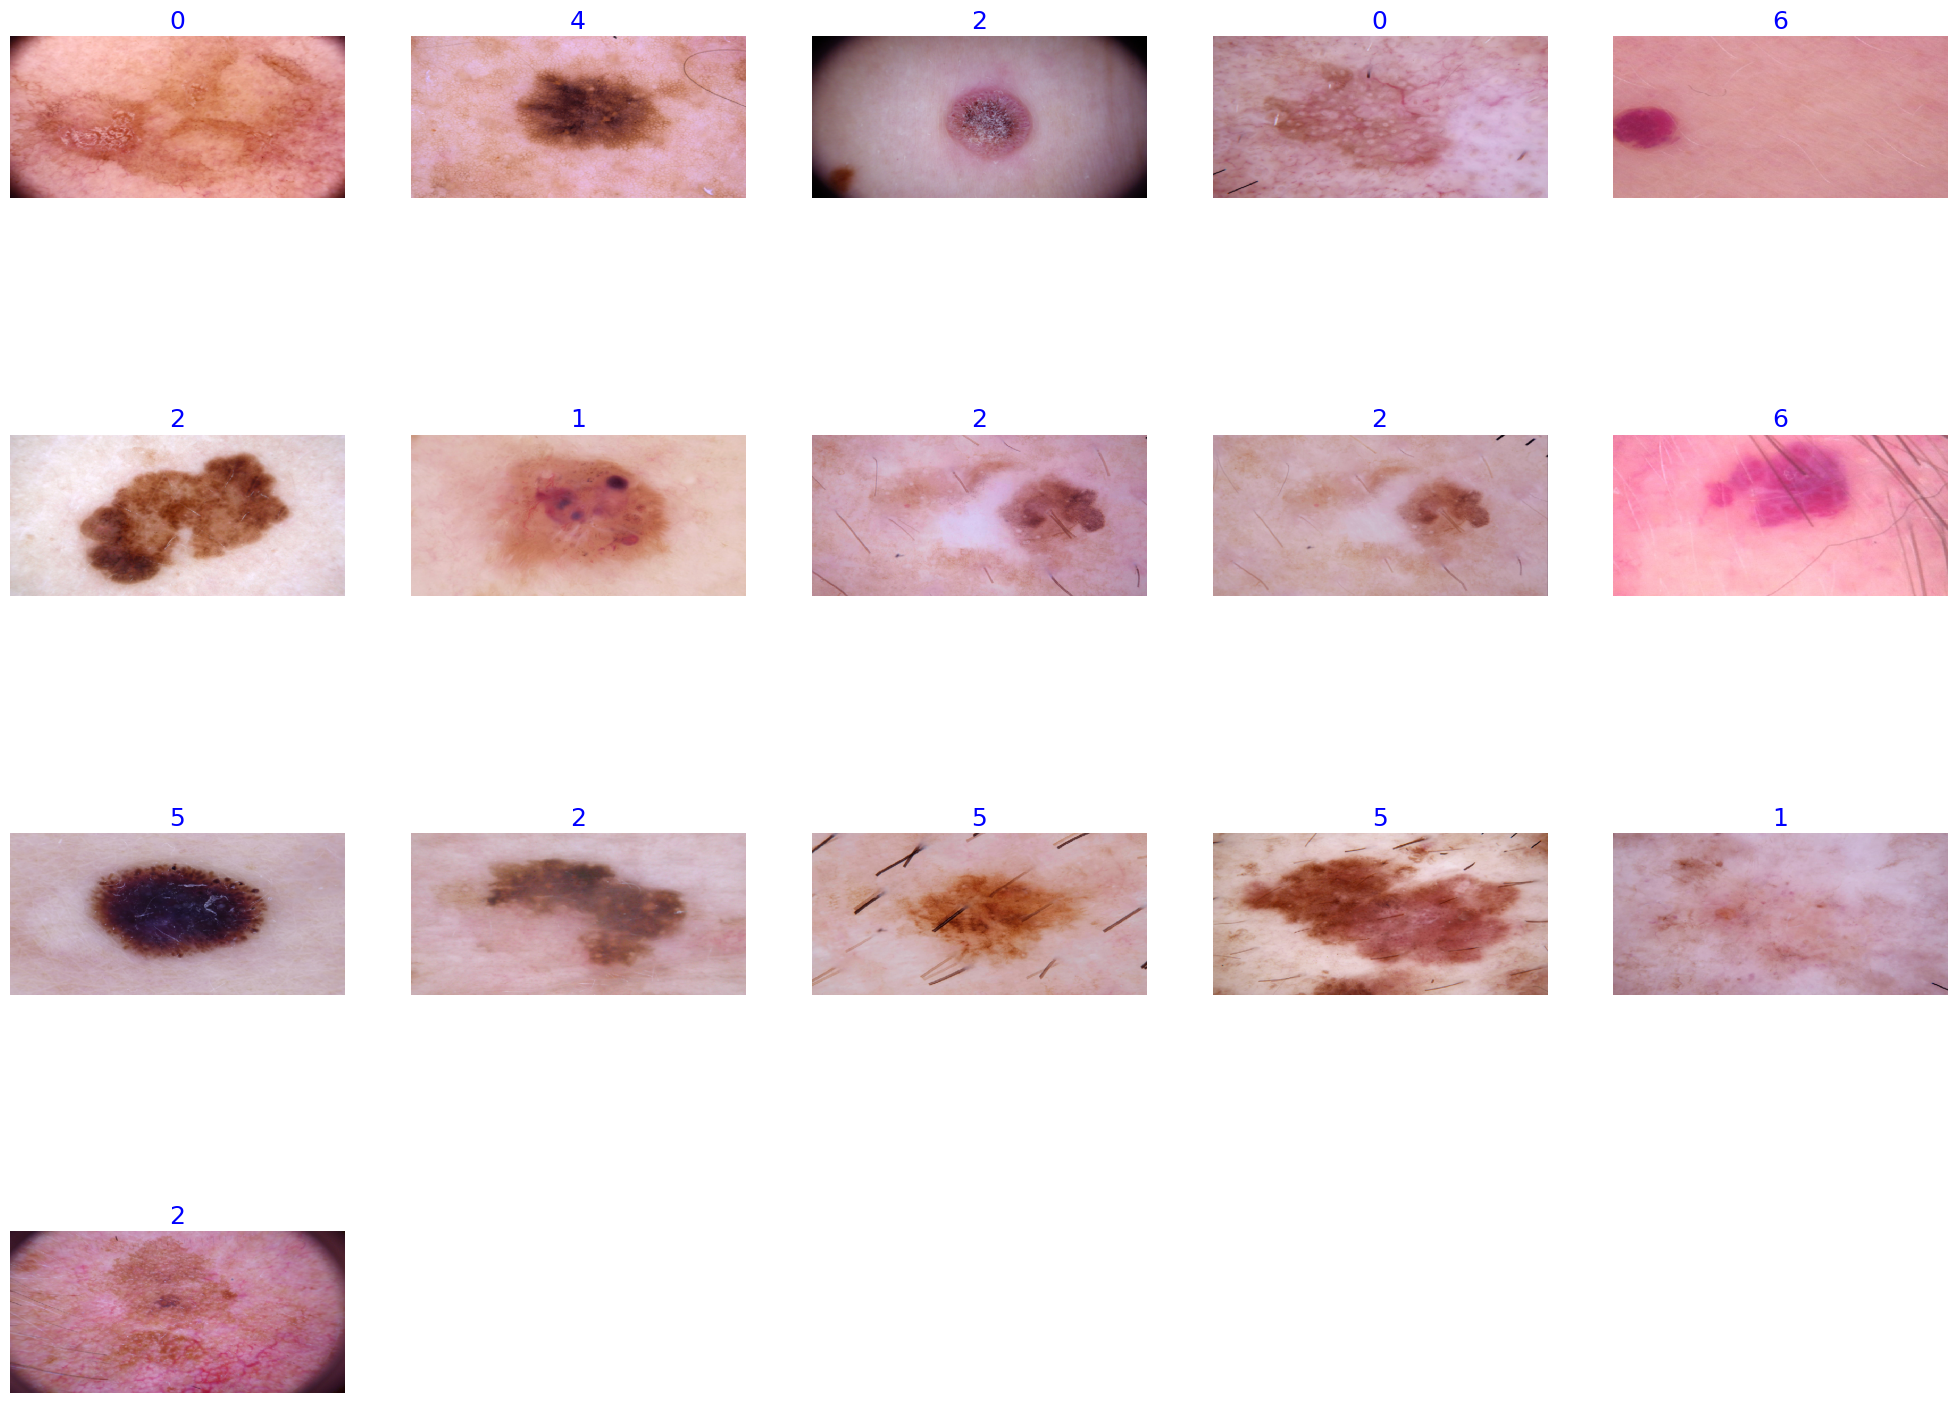

In [12]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [13]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
img_shape=(img_size[0], img_size[1], 3)

In [15]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=img_shape, pooling='max')

In [16]:
base_model.trainable= True

In [17]:
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
    # Evidential Begins
model.compile(Adamax(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 310, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 154, 319, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 154, 319, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 2D)                                                                                              
                                                                                                  
 block4_sepconv1_bn (BatchNorma  (None, 38, 80, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 38, 80, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 38, 80, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
          

                                                                                                  
 block7_sepconv1_act (Activatio  (None, 19, 40, 728)  0          ['add_4[0][0]']                  
 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 40, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 40, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_se

 2D)                                                                                              
                                                                                                  
 block9_sepconv3_bn (BatchNorma  (None, 19, 40, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 40, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 40, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
          

 block12_sepconv2_bn (BatchNorm  (None, 19, 40, 728)  2912       ['block12_sepconv2[0][0]']       
 alization)                                                                                       
                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 40, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 40, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 40, 728)  2912       ['block12_sepconv3[0][0]']       
 alization

In [19]:
history=model.fit(x=train_gen, batch_size=8,  epochs=50, verbose=1,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False, initial_epoch=0)

Epoch 1/50
219/219 [==============================] - 75s 314ms/step - loss: 8.7735 - accuracy: 0.5600 - F1_score: 0.5453 - auc: 0.8756 - val_loss: 7.6049 - val_accuracy: 0.6933 - val_F1_score: 0.6497 - val_auc: 0.9419
Epoch 2/50
219/219 [==============================] - 66s 301ms/step - loss: 6.9244 - accuracy: 0.7660 - F1_score: 0.7508 - auc: 0.9652 - val_loss: 6.4793 - val_accuracy: 0.7173 - val_F1_score: 0.7066 - val_auc: 0.9567
Epoch 3/50
219/219 [==============================] - 65s 295ms/step - loss: 5.7431 - accuracy: 0.8597 - F1_score: 0.8438 - auc: 0.9840 - val_loss: 5.4883 - val_accuracy: 0.7493 - val_F1_score: 0.7354 - val_auc: 0.9589
Epoch 4/50
219/219 [==============================] - 65s 297ms/step - loss: 4.7903 - accuracy: 0.8889 - F1_score: 0.8789 - auc: 0.9899 - val_loss: 4.6548 - val_accuracy: 0.7812 - val_F1_score: 0.7727 - val_auc: 0.9644
Epoch 5/50
219/219 [==============================] - 65s 295ms/step - loss: 3.9352 - accuracy: 0.9271 - F1_score: 0.9146 - 

219/219 [==============================] - 62s 283ms/step - loss: 0.1295 - accuracy: 0.9991 - F1_score: 0.9990 - auc: 1.0000 - val_loss: 0.8503 - val_accuracy: 0.8082 - val_F1_score: 0.8078 - val_auc: 0.9545
Epoch 39/50
219/219 [==============================] - 62s 284ms/step - loss: 0.1405 - accuracy: 0.9963 - F1_score: 0.9958 - auc: 0.9995 - val_loss: 0.9964 - val_accuracy: 0.7782 - val_F1_score: 0.7801 - val_auc: 0.9403
Epoch 40/50
219/219 [==============================] - 62s 285ms/step - loss: 0.1238 - accuracy: 0.9994 - F1_score: 0.9994 - auc: 1.0000 - val_loss: 1.1760 - val_accuracy: 0.7532 - val_F1_score: 0.7546 - val_auc: 0.9219
Epoch 41/50
219/219 [==============================] - 62s 284ms/step - loss: 0.1332 - accuracy: 0.9966 - F1_score: 0.9954 - auc: 1.0000 - val_loss: 0.9079 - val_accuracy: 0.7972 - val_F1_score: 0.7933 - val_auc: 0.9489
Epoch 42/50
219/219 [==============================] - 62s 284ms/step - loss: 0.1298 - accuracy: 0.9977 - F1_score: 0.9971 - auc: 1.

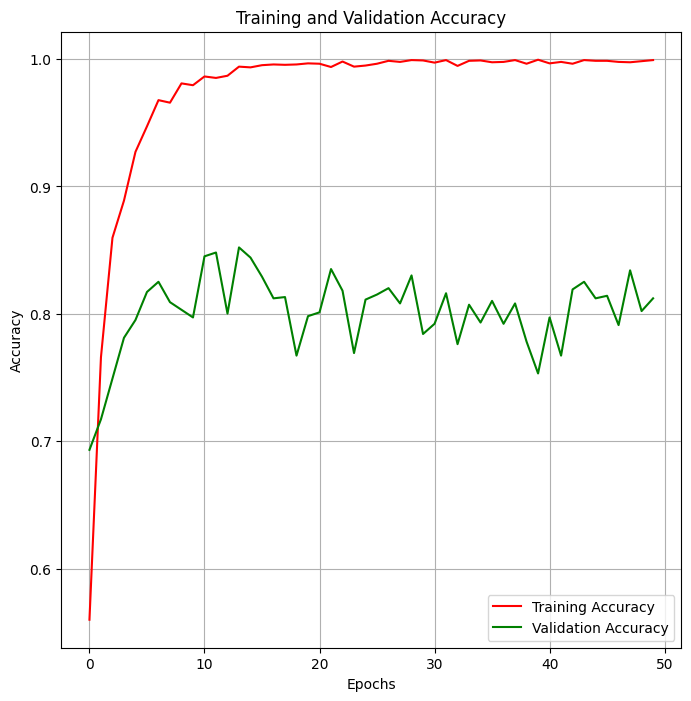

In [20]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

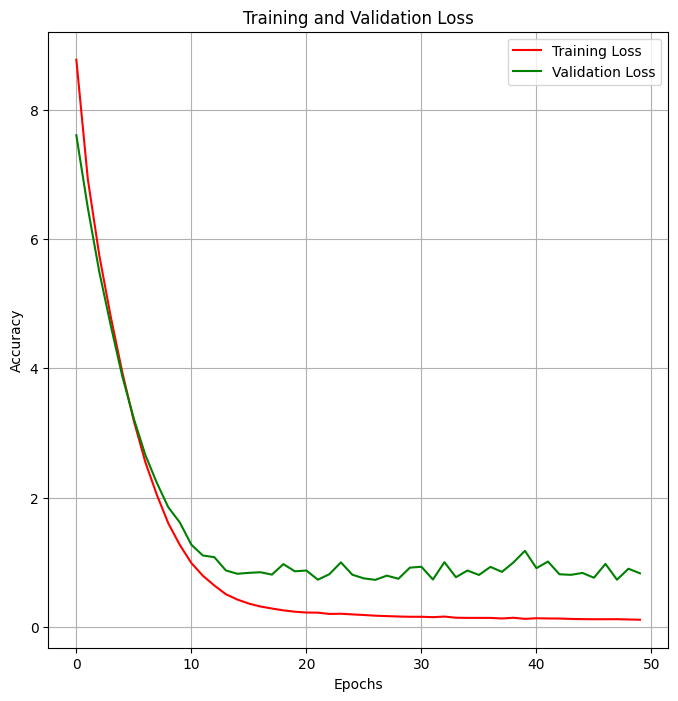

In [21]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], 'r', label='Training Loss')
plt.plot(history.history['val_loss'], 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

167/167 [==============================] - 12s 63ms/step
there were 193 errors in 1002 tests for an accuracy of  80.74


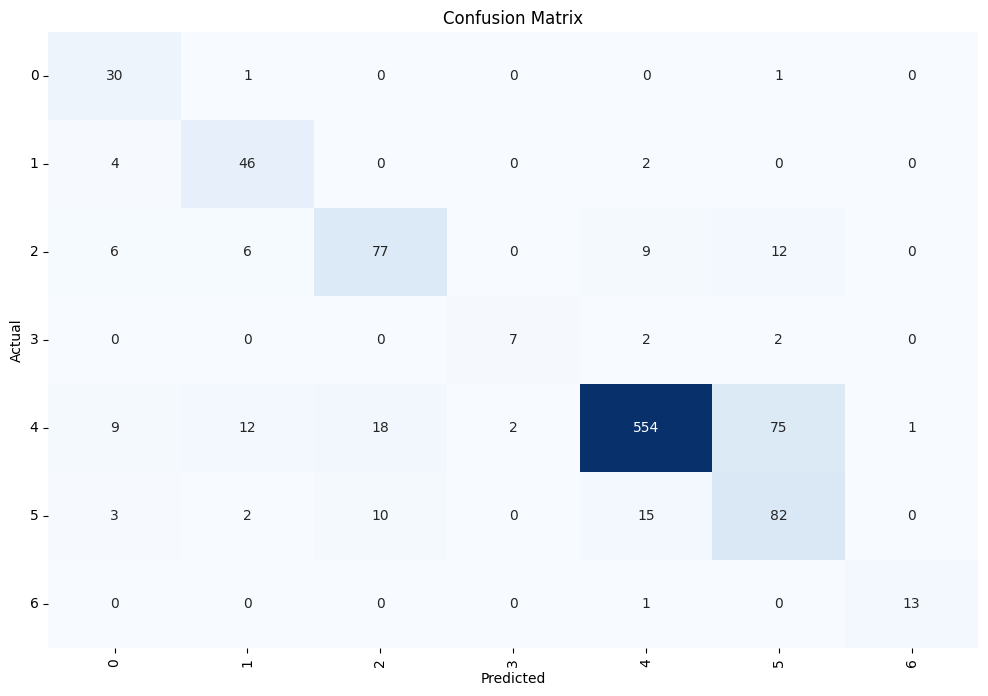

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.5769    0.9375    0.7143        32
           1     0.6866    0.8846    0.7731        52
           2     0.7333    0.7000    0.7163       110
           3     0.7778    0.6364    0.7000        11
           4     0.9503    0.8256    0.8836       671
           5     0.4767    0.7321    0.5775       112
           6     0.9286    0.9286    0.9286        14

    accuracy                         0.8074      1002
   macro avg     0.7329    0.8064    0.7562      1002
weighted avg     0.8457    0.8074    0.8185      1002



In [22]:
from sklearn.metrics import confusion_matrix 

def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print(msg)
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score, y_pred, y_true

errors, tests, error_list, error_pred_list, f1score, y_pred, y_true = predictor(test_gen)

In [23]:
model.save('my_model.h5')